# GNN V1

An attempt to use keras to build out a graph neural network and predict the user (label) using the dataset columns (features).

## Import and Initialize

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

2021-07-16 20:35:54.194010: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-16 20:35:54.194061: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load Data

In [2]:
dsp = pd.read_csv("data/dsp_cookies_export_20210625_10k.csv")
print(f"DSP data shape: {dsp.shape}")

sizmek = pd.read_csv("data/sizmek_bidstream_raw_20210625_10k.csv")
print(f"Sizmek data shape: {sizmek.shape}")

# Fix column headers
dsp.columns = [i.split(".")[1] for i in dsp.columns]
sizmek.columns = [i.split(".")[1] for i in sizmek.columns]

DSP data shape: (10000, 3)
Sizmek data shape: (10000, 16)


## Transform to Graph Format
**Goal:** Achieve this format here: https://keras.io/examples/graph/gnn_citations/
- Below are some examples of the current data structures:

In [3]:
sizmek.head(1)

,user_id,household_cluster_id,zeta_user_id,account_id,url,referrer_url,city_code,state_code,zip_code,dma_code,country_code,user_agent,mobile_id,ip,server_timestamp,dt
0,163543465731194,NaN,NaN,19967,http://mob.app.de.wetteronline.wetterapp,NaN,3103824.0,NaN,NaN,NaN,PL,Mozilla/5.0 (Linux; Android 11; SM-A715F Build...,b7f4d610-7879-4394-aa2b-bfb9f2b1c25b,31.0.26.0,1624622086664,20210625


In [4]:
dsp.head(3)

,user_id,zeta_user_id,dt
0,466393253621502,"[""4bbbcada-3976-44c8-8962-e5a99d2eda97:1591197...",20210625
1,516673890397218,"[""9ad67b74-2e30-423d-8532-9e6a56ff6176:1610871...",20210625
2,552427950674755,"[""b8f83981-fb82-429a-bf53-74c17001d341:1599091...",20210625


In [5]:
sizmek[['user_id','zeta_user_id']].sample(3)

,user_id,zeta_user_id
6333,57052281873774128,fa3e335a-6b70-45b0-a9fb-ac71d098a924:161377748...
5340,47789607384682366,NaN
9997,57052281873774128,fa3e335a-6b70-45b0-a9fb-ac71d098a924:161377748...


Ideally we want to get Source/Target interaction tuples. But what are the interactions in this dataset? There are no explicit sample-to-sample interactions here, it is all implicit via sample features such as URL, city, timestamp.

One thought: If two samples ARE the same user the features should match up (IP, user_agent, geo), with the exception of timestamps.

## Attempt 1: Do Some Loops
Let's create a 'connection' by looping through all rows for each row if there are any matching attribtutes in one of the select features (IP, user-agent, email, etc)

In [6]:
%%time

matching_cols = ["ip", "user_agent"]

def search_table(table, column, value):
    match_indices = []
    for ix, row in table.iterrows():
        if value == row[column]:
            match_indices.append(ix)
    print(f"Found {len(match_indices)} matches")


for ix, user_id in enumerate(sizmek["user_id"]):
    print(user_id)
    search_table(sizmek, "user_id", user_id)
    break

163543465731194
Found 9 matches
CPU times: user 360 ms, sys: 1.05 ms, total: 361 ms
Wall time: 357 ms


### Result: Not Good!
It appears that a single search is on the order of `O(n^2)` complexity and for just 10k rows in this sample it takes ~300ms for a single iteration. This is completely infeasable for larger sizes. But that is something that can likely be fixed later on with pre-computed hashes. I'm thinking maybe a dictionary lookup where the dictionary key is the value we are searching for, and the dictionary value is the indices where this value is located. It can simply be updated as more rows are added.

## Attempt 2: Dictionary Lookup
There is no reason I should be iterating through the entire table for each value in the table, that's what hash lookups are for! So let's create a dictionary and use that to search for the value in each table.

In [7]:
%%time

def create_dict(table, col):
    table_dict = {}
    for ix, value in enumerate(table[col]):
        #print(value)
        if value in table_dict:
            table_dict[value].append(ix)
        else:
            table_dict[value] = [ix]
    return table_dict

def search_table(table, column):
    connections = []
    lookup_dict = create_dict(table, column)
    for ix, value in enumerate(table[column]):
        if value in lookup_dict:
            for item in lookup_dict[value]:
                connections.append((ix, item, column, value))
    connections = pd.DataFrame(
        connections, 
        columns=['source', 'target', 'column', 'value']
    )
    return connections

# Create three edge lists for some features
ip_graph = search_table(sizmek, "ip")
ua_graph = search_table(sizmek, "user_agent")
zip_graph = search_table(sizmek, "zip_code")

CPU times: user 21.4 s, sys: 2.07 s, total: 23.4 s
Wall time: 23.4 s


### Result: Very Good!
I can now search the entire table for three different features in only 24 seconds, this will be much more managable to scale up in the future when using millions of rows.

In [8]:
ip_graph.sample(3)

,source,target,column,value
5906812,7239,7154,ip,71.218.146.124
12531292,8889,6884,ip,71.218.146.124
7404275,7612,7022,ip,71.218.146.124


### Example Plot of the Graph Network

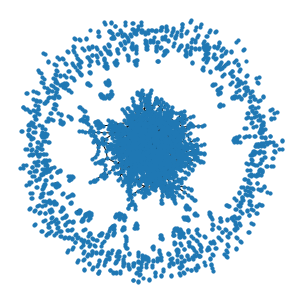

In [9]:
plt.figure(figsize=(4, 4))
g = nx.from_pandas_edgelist(zip_graph.sample(n=3000))
nx.draw_spring(g, node_size=10)

## Create the Network

In [11]:
sizmek.head(2)

,user_id,household_cluster_id,zeta_user_id,account_id,url,referrer_url,city_code,state_code,zip_code,dma_code,country_code,user_agent,mobile_id,ip,server_timestamp,dt
0,163543465731194,NaN,NaN,19967,http://mob.app.de.wetteronline.wetterapp,NaN,3103824.0,NaN,NaN,NaN,PL,Mozilla/5.0 (Linux; Android 11; SM-A715F Build...,b7f4d610-7879-4394-aa2b-bfb9f2b1c25b,31.0.26.0,1624622086664,20210625
1,163543465731194,NaN,NaN,19967,http://mob.app.de.wetteronline.wetterapp,NaN,3103824.0,NaN,NaN,NaN,PL,Mozilla/5.0 (Linux; Android 11; SM-A715F Build...,b7f4d610-7879-4394-aa2b-bfb9f2b1c25b,31.0.26.0,1624622151478,20210625


In [12]:
ip_graph.head(3)

,source,target,column,value
0,0,0,ip,31.0.26.0
1,0,1,ip,31.0.26.0
2,0,2,ip,31.0.26.0


In [22]:
sizmek['account_id'].value_counts()

19967    5194
35927    4806
Name: account_id, dtype: int64

In [20]:
from sklearn.preprocessing import OneHotEncoder
feature_cols = ["account_id", "url", "referrer_url", "city_code", "state_code", "dma_code", "country_code"]

encoder_list = []
for feature in feature_cols:
    print(feature)
    enc = OneHotEncoder(handle_unknown='ignore')
    enc_df = pd.DataFrame(enc.fit_transform(sizmek[[feature]]).toarray())
    break

enc_df

account_id


,0,1
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
9995,0.0,1.0
9996,0.0,1.0
9997,0.0,1.0
9998,0.0,1.0


In [10]:
feature_cols = ["account_id", "url", "referrer_url", "city_code", "state_code", "dma_code", "country_code"]

# Edges array (sparse adjacency matrix) of shape [2, num_edges]
edges = ip_graph[["source", "target"]].to_numpy().T
# Default edge weights to 1 (we don't have any in dataset)
edge_weights = tf.ones(shape=edges.shape[1])
# Node fatures array of shape [num_nodes, num_features]
#node_features = tf.cast(sizmek.sort_index()[feature_cols].to_numpy(), dtype=tf.dtypes.float32

2021-07-16 20:36:47.793276: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-16 20:36:47.830574: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: UNKNOWN ERROR (100)
2021-07-16 20:36:47.830603: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cube): /proc/driver/nvidia/version does not exist
2021-07-16 20:36:47.831028: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


TypeError: cast() missing 2 required positional arguments: 'x' and 'dtype'

In [ ]:
sizmek